In [1]:
%cd drive/MyDrive/SHAP/

/content/drive/MyDrive/SHAP


In [5]:
!pip install transformers
import numpy as np
import itertools
from itertools import combinations
import torch
from copy import deepcopy
from __future__ import absolute_import, division, print_function

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import argparse
import glob
import logging
import os
import random
import itertools
import numpy as np
import torch
# import hedge_bert as hedge
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange
from copy import copy, deepcopy
# from pytorch_transformers import (WEIGHTS_NAME, BertConfig,BertForSequenceClassification, BertTokenizer)

# from pytorch_transformers import AdamW, WarmupLinearSchedule

from utils_glue import (convert_examples_to_features,output_modes, processors)
import time
logger = logging.getLogger(__name__)

In [6]:
def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

def load_and_cache_examples(args, task, tokenizer, type):
    processor = processors[task]()
    output_mode = output_modes[task]
    label_list = processor.get_labels()
    cached_features_file = os.path.join(args.data_dir, 'cached_{}_{}_{}_{}'.format(
        type,
        list(filter(None, args.model_name_or_path.split('/'))).pop(),
        str(args.max_seq_length),
        str(task)))
    examples = processor.get_train_examples(args.data_dir)
    print(examples)
    # examples = ['By comparison , it cost $ 103.7 million to build the NoMa infill Metro station , which opened in 2004 .']
    # label_list = ['pos','neg']
    output_mode = output_modes[task]
    
    features = convert_examples_to_features(examples, label_list, args.max_seq_length, tokenizer, output_mode,
                                            cls_token_at_end=bool(args.model_type in ['xlnet']),
                                            # xlnet has a cls token at the end
                                            cls_token=tokenizer.cls_token,
                                            cls_token_segment_id=2 if args.model_type in ['xlnet'] else 0,
                                            sep_token=tokenizer.sep_token,
                                            sep_token_extra=bool(args.model_type in ['roberta']),
                                            # roberta uses an extra separator b/w pairs of sentences, cf. github.com/pytorch/fairseq/commit/1684e166e3da03f5b600dbb7855cb98ddfcd0805
                                            pad_on_left=bool(args.model_type in ['xlnet']),
                                            # pad on the left for xlnet
                                            pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                                            pad_token_segment_id=4 if args.model_type in ['xlnet'] else 0,
                                            )
    logger.info("Saving features into cached file %s", cached_features_file)
    torch.save(features, cached_features_file)
    
    # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    for f in features:
      print(f.ori_token)
    if output_mode == "classification":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    elif output_mode == "regression":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.float)
    dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    return dataset

In [7]:
class arg(object):
  def __init__(self):
    self.data_dir = './dataset/IMDB'
    self.model_type = 'bert'
    self.model_name_or_path = 'bert-base-uncased' 
    # self.model_name_or_path = 'gilf/english-yelp-sentiment'
    self.task_name = 'sst-2'
    self.output_dir = './output/IMDB'
    self.max_seq_length = 250
    self.start_pos = 0
    self.end_pos = 2000
    self.visualize = 1
    self.per_gpu_eval_batch_size = 1
    self.n_gpu = 1
    self.device = 'cuda'
args = arg()

In [8]:
def evaluate(args, model, tokenizer, eval_dataset, fileobject, start_pos=0, end_pos=100, vis=-1):
    eval_output_dir = args.output_dir
    if not os.path.exists(eval_output_dir):
        os.makedirs(eval_output_dir)

    args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)
    # Note that DistributedSampler samples randomly
    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=1)

    # Eval!
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    count = start_pos
    start_time = time.time()
    results = []
    num =0
    for batch in itertools.islice(eval_dataloader, start_pos, end_pos):
        num+=1
        print(num)
        model.eval()
        batch = tuple(t.to(args.device) for t in batch)
        count += 1
        fileobject.write(str(count))
        fileobject.write('\n')
        
        ori_text_idx = list(batch[0].cpu().numpy()[0])
        if 0 in ori_text_idx:
            ori_text_idx = [idx for idx in ori_text_idx if idx != 0]
        pad_start = len(ori_text_idx)
        print('len:',pad_start)
        print('first')
        with torch.no_grad():
            inputs = {'input_ids':      torch.unsqueeze(batch[0][0,:pad_start], 0),
                  'attention_mask': torch.unsqueeze(batch[1][0,:pad_start], 0),
                  'token_type_ids': torch.unsqueeze(batch[2][0,:pad_start], 0) if args.model_type in ['bert', 'xlnet'] else None,  # XLM and RoBERTa don't use segment_ids
                  'labels':         batch[3]}
            # print(inputs)
            outputs = model(**inputs)
            global tttest
            tttest = outputs[-1]
            # print(len(outputs))
            # print(outputs)
            tmp_eval_loss, logits = outputs[:2]

            eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        
        # print(count,len(inputs['input_ids'][0]) - 2)
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs['labels'].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

        for btxt in ori_text_idx:
            if (tokenizer.ids_to_tokens[btxt] != '[CLS]' and tokenizer.ids_to_tokens[btxt] != '[SEP]'):
                fileobject.write(tokenizer.ids_to_tokens[btxt])
                fileobject.write(' ')
        fileobject.write(' >> ')
        if batch[3].cpu().numpy()[0] == 0:
            fileobject.write('0')
            fileobject.write(' ||| ')
        else:
            fileobject.write('1')
            fileobject.write(' ||| ')

        shap = HEDGE(model, inputs, args, thre=100)
        res = shap.shapely_matrix(model,inputs)
        results.append(res)
    return results

In [ ]:
def get_shapley_interaction_weight(d, s):
      return np.math.factorial(s) * np.math.factorial(d - s - 1) / np.math.factorial(d)

In [ ]:
get_shapley_interaction_weight(10,9)

0.1

+CLS

In [ ]:
class HEDGE:
    def __init__(self, model, inputs, args, max_level=-1, thre=0.3):
        score = model(**inputs)[1].detach().cpu().numpy()
        score_norm = (np.exp(score) / np.sum(np.exp(score), axis=1))
        self.pred_label = np.argmax(score_norm)
        self.max_level = max_level
        self.output = []
        self.fea_num = len(inputs['input_ids'][0]) - 1
        self.level = 0
        self.args = args
        self.thre = thre
        input = inputs['input_ids'][0]
        
        mask_input = torch.zeros(input.shape, dtype=torch.long)
        mask_attention = torch.zeros(input.shape, dtype=torch.long)
        mask_type = torch.zeros(input.shape, dtype=torch.long)
        temp = {'input_ids': torch.unsqueeze(mask_input, 0).to(args.device),
                'attention_mask': torch.unsqueeze(mask_attention, 0).to(args.device),
                'token_type_ids': torch.unsqueeze(mask_type, 0).to(args.device),
                'labels': inputs['labels']}
        print(inputs['labels'])
        # score = model(**temp)[1].detach().cpu().numpy()
        # print((np.exp(score) / np.sum(np.exp(score), axis=1)))
        # global tttscore
        # tttscore = score
        # score_norm = (np.exp(score) / np.sum(np.exp(score), axis=1))
        with torch.no_grad():
          ori_score = model(**temp)[-1][12].cpu().numpy()
          # ori_score = ori_score[0]
        self.ori_score = ori_score

    def set_contribution_func(self, model, fea_set, inputs, ori,tar):
      # input has just one sentence, input is a list
      args = self.args
      input = inputs['input_ids'][0]
      mask_input = torch.full(input.shape,tokenizer.mask_token_id)
      mask_input[0] = input[0]
      mask_input[-1] = input[-1]
      mask_attention = torch.zeros(input.shape, dtype=torch.long)
      # mask_attention[0] = 1
      mask_attention[-1] = 1
      # mask_attention[ori] = 1
      # mask_input[ori] = input[ori]
      mask_type = torch.zeros(input.shape, dtype=torch.long)

      # mask the input with zero
      for fea_idx in fea_set:
          if type(fea_idx) == int:
              mask_input[fea_idx] = input[fea_idx] #+1 accounts for the CLS token at the begining
              mask_attention[fea_idx] = 1 #+1 accounts for the CLS token at the begining
          else:
              for idx in fea_idx:
                  mask_input[idx] = input[idx] #+1 accounts for the CLS token at the begining
                  mask_attention[idx] = 1 #+1 accounts for the CLS token at the begining
      temp = {'input_ids': torch.unsqueeze(mask_input, 0).to(args.device),
              'attention_mask': torch.unsqueeze(mask_attention, 0).to(args.device),
              'token_type_ids': torch.unsqueeze(mask_type, 0).to(args.device),
              'labels': inputs['labels']}
      # send the mask_input into model
      with torch.no_grad():
        score = model(**temp)[-1][12][:, ori, :].cpu().numpy()
        score = score[0]
      # score = score[12][:, word_pos, :] 

      mask_input[tar] = input[tar]
      mask_attention[tar] = 1
      temp = {'input_ids': torch.unsqueeze(mask_input, 0).to(args.device),
              'attention_mask': torch.unsqueeze(mask_attention, 0).to(args.device),
              'token_type_ids': torch.unsqueeze(mask_type, 0).to(args.device),
              'labels': inputs['labels']}

      with torch.no_grad():
        score2 = model(**temp)[-1][12][:, ori, :].cpu().numpy()
        score2 = score2[0]
      
      return np.linalg.norm(score - score2)
      # return np.dot(score, score2) / (np.linalg.norm(score) * np.linalg.norm(score2))

    def shapely_matrix(self,model,inputs):
      fea_num = self.fea_num
      if fea_num == 0:
        return -1
      fea_set = list(range(fea_num))
      print(fea_set)
      scores = [[] for i in range(len(fea_set))]
      for i in fea_set:
        for j in fea_set:
          if i==j:
            scores[i].append(0)
            continue
          print(i,j)
          new_fea_set = [ele for x, ele in enumerate(fea_set) if x!=j and x!=i]
          # print(new_fea_set)
          scores[i].append(self.shapely_value(model,inputs,new_fea_set,i,j))
      return scores

    def get_shapley_interaction_weight(self, d, s):
      return np.math.factorial(s) * np.math.factorial(d - s - 1) / np.math.factorial(d)

    def shapely_value(self,model,inputs,feature_set,ori,tar):
      fea_num = len(feature_set)
      dict_subset = {r: list(combinations(feature_set, r)) for r in range(fea_num+1)}
      score = 0.0
      for i in range(fea_num+1):
        # if i<(fea_num+1)*0.9:
        #   continue
        if i<fea_num-2:
          continue
        weight = self.get_shapley_interaction_weight(fea_num+1, i)
        if i==0:
          continue
        for subsets in dict_subset[i]:
          contri = self.set_contribution_func(model,list(subsets),inputs,ori,tar)
          # if tar==11:
          #   print(contri)
          score += contri*weight

      # print(score)
      return score

No cls

In [9]:
class HEDGE:
    def __init__(self, model, inputs, args, max_level=-1, thre=0.3):
        score = model(**inputs)[1].detach().cpu().numpy()
        score_norm = (np.exp(score) / np.sum(np.exp(score), axis=1))
        self.pred_label = np.argmax(score_norm)
        self.max_level = max_level
        self.output = []
        self.fea_num = len(inputs['input_ids'][0]) - 2
        self.level = 0
        self.args = args
        self.thre = thre
        input = inputs['input_ids'][0]
        mask_input = torch.zeros(input.shape, dtype=torch.long)
        mask_attention = torch.zeros(input.shape, dtype=torch.long)
        mask_type = torch.zeros(input.shape, dtype=torch.long)
        print('sdhausd')
        temp = {'input_ids': torch.unsqueeze(mask_input, 0).to(args.device),
                'attention_mask': torch.unsqueeze(mask_attention, 0).to(args.device),
                'token_type_ids': torch.unsqueeze(mask_type, 0).to(args.device),
                'labels': inputs['labels']}
        # score = model(**temp)[1].detach().cpu().numpy()
        # score_norm = (np.exp(score) / np.sum(np.exp(score), axis=1))
        print('111111111111')
        with torch.no_grad():
          ori_score = model(**temp)[-1][12].cpu().numpy()
          # ori_score = ori_score[0]
        print('22222222222222')
        self.ori_score = ori_score

    def set_contribution_func(self, model, fea_set, inputs, ori,tar):
      # input has just one sentence, input is a list
      args = self.args
      input = inputs['input_ids'][0]
      mask_input = torch.full(input.shape,tokenizer.mask_token_id)
      mask_input[0] = input[0]
      mask_input[-1] = input[-1]
      mask_attention = torch.zeros(input.shape, dtype=torch.long)
      mask_attention[0] = 1
      mask_attention[-1] = 1
      # mask_attention[ori+1] = 1
      # mask_input[ori+1] = input[ori+1]
      mask_type = torch.zeros(input.shape, dtype=torch.long)

      # mask the input with zero
      for fea_idx in fea_set:
          if type(fea_idx) == int:
              mask_input[fea_idx+1] = input[fea_idx+1] #+1 accounts for the CLS token at the begining
              mask_attention[fea_idx+1] = 1 #+1 accounts for the CLS token at the begining
          else:
              for idx in fea_idx:
                  mask_input[idx+1] = input[idx+1] #+1 accounts for the CLS token at the begining
                  mask_attention[idx+1] = 1 #+1 accounts for the CLS token at the begining
      temp = {'input_ids': torch.unsqueeze(mask_input, 0).to(args.device),
              'attention_mask': torch.unsqueeze(mask_attention, 0).to(args.device),
              'token_type_ids': torch.unsqueeze(mask_type, 0).to(args.device),
              'labels': inputs['labels']}
      # send the mask_input into model
      with torch.no_grad():
        score = model(**temp)[-1][12][:, ori+1, :].cpu().numpy()
        score = score[0]
      # score = score[12][:, word_pos, :] 
      # print(mask_attention)
      mask_input[tar+1] = input[tar+1]
      mask_attention[tar+1] = 1

      temp = {'input_ids': torch.unsqueeze(mask_input, 0).to(args.device),
              'attention_mask': torch.unsqueeze(mask_attention, 0).to(args.device),
              'token_type_ids': torch.unsqueeze(mask_type, 0).to(args.device),
              'labels': inputs['labels']}

      with torch.no_grad():
        score2 = model(**temp)[-1][12][:, ori+1, :].cpu().numpy()
        score2 = score2[0]
      # print(mask_attention)
      # print(score)
      # print(score2)
      return np.linalg.norm(score - score2)
      # return np.dot(score, score2) / (np.linalg.norm(score) * np.linalg.norm(score2))

    def shapely_matrix(self,model,inputs):
      print('333333333')
      fea_num = self.fea_num
      if fea_num == 0:
        return -1
      fea_set = list(range(fea_num))
      scores = [[] for i in range(len(fea_set))]
      print('44444444444')
      for i in fea_set:
        for j in fea_set:
          if i==j:
            scores[i].append(0)
            continue
          # print(i,j)
          new_fea_set = [ele for x, ele in enumerate(fea_set) if x!=j and x!=i]
          # print(new_fea_set)
          scores[i].append(self.shapely_value(model,inputs,new_fea_set,i,j))
      return scores

    def get_shapley_interaction_weight(self, d, s):
      return np.math.factorial(s) * np.math.factorial(d - s - 1) / np.math.factorial(d)

    def shapely_value(self,model,inputs,feature_set,ori,tar):
      # print('5555555555555')
      fea_num = len(feature_set)
      # dict_subset = {r: list(combinations(feature_set, r)) for r in range(fea_num+1)}
      # print('66666666666')
      score = 0.0
      for i in range(fea_num+1):
        # if i<(fea_num+1)*0.9:
        #   continue
        if i<fea_num:
          continue
        weight = self.get_shapley_interaction_weight(fea_num+1, i)
        if i==0:
          continue
        i_subsets = list(combinations(feature_set,i))
        for subsets in i_subsets:
          contri = self.set_contribution_func(model,list(subsets),inputs,ori,tar)
          score += contri*weight

      # print(score)
      return score

In [ ]:
dict_subset = {r: list(combinations(feature_set, r)) for r in range(fea_num+1)}

In [10]:
from transformers import BertModel, BertTokenizer,BertForSequenceClassification,RobertaModel,RobertaTokenizer,RobertaForSequenceClassification
# MODEL_CLASSES = {
#         'bert': (BertModel, BertTokenizer, 'gilf/english-yelp-sentiment'),
#         'roberta': (RobertaModel, RobertaTokenizer,'roberta-base')
#     }
MODEL_CLASSES = {
        'bert': (BertModel, BertTokenizer, 'bert-base-uncased'),
    }
model_class, tokenizer_class, pretrained_weights = MODEL_CLASSES['bert']
# model = RobertaForSequenceClassification.from_pretrained(pretrained_weights, output_hidden_states=True)
model = BertForSequenceClassification.from_pretrained(pretrained_weights, output_hidden_states=True)
tokenizer = tokenizer_class.from_pretrained(pretrained_weights, do_lower_case=True)
# from transformers import AutoTokenizer, AutoModelForSequenceClassification
  
# tokenizer = AutoTokenizer.from_pretrained("barissayil/bert-sentiment-analysis-sst",use_fast=False, do_lower_case=True)

# model = AutoModelForSequenceClassification.from_pretrained("barissayil/bert-sentiment-analysis-sst",output_hidden_states=True)

model.to('cuda')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
from utils_glue import (convert_examples_to_features,output_modes, processors)
test_dataset = load_and_cache_examples(args, args.task_name, tokenizer, type='test')
res = []
start_pos = args.start_pos
end_pos = args.end_pos
with open('test.txt', 'w') as f:
  res = evaluate(args, model, tokenizer, test_dataset, f, start_pos, end_pos, args.visualize)

['but', 'in', 'a', 'break', 'from', 'his', 'past', 'rhetoric', 'about', 'curt', '##ailing', 'immigration', ',', 'the', 'go', '##p', 'nominee', 'proclaimed', 'that', 'as', 'president', 'he', 'would', 'allow', '“', 'tremendous', 'numbers', '”', 'of', 'legal', 'immigrants', 'based', 'on', 'a', '“', 'merit', 'system', '.']
1
len: 40


In [ ]:
def normalize(data):
  maxn = -1000
  minn = 10000
  for i in data:
    for j in i:
      if j>maxn:
        maxn=j
      if j<minn:
        minn=j

  for i in range(len(data)):
    for j in range(len(data[0])):
      data[i][j] = (data[i][j]-minn)/(maxn-minn)
  return data

In [ ]:
pd_data2=pd_data
print(pd_data2.apply(lambda x: pd.to_numeric(x, errors='coerce').sum(), axis=1))

NameError: ignored

In [ ]:
pd_data2

,[CLS],this,movie,is,terrible,but,it,has,some,bad,effects,.,Col_sum
[CLS],0.000000,0.118401,0.132642,0.150094,0.076939,0.219181,0.124283,0.130801,0.123237,0.102245,0.191537,0.183346,1.552707
this,0.164899,0.000000,0.235622,0.274648,0.170702,0.352566,0.226013,0.239675,0.286102,0.151433,0.258496,0.360965,2.721120
movie,0.169424,0.331599,0.000000,0.340057,0.184483,0.310000,0.222197,0.256543,0.261285,0.209033,0.243955,0.326847,2.855423
is,0.131283,0.266300,0.295334,0.000000,0.280185,0.262414,0.121911,0.140102,0.135676,0.091833,0.153451,0.190071,2.068561
terrible,0.315855,0.350777,0.516323,0.581164,0.000000,0.662304,0.362376,0.410822,0.433085,0.338672,0.381198,0.650651,5.003227
but,0.473894,0.384434,0.386007,0.510653,0.411914,0.000000,0.464041,0.509196,0.578072,0.304248,0.505875,0.945253,5.473587
it,0.099744,0.101286,0.102455,0.127682,0.061576,0.271835,0.000000,0.211778,0.119718,0.106423,0.141303,0.162743,1.506544
has,0.073062,0.081234,0.099410,0.128070,0.088564,0.214670,0.201543,0.000000,0.154654,0.169967,0.226461,0.128101,1.565735
some,0.185565,0.240980,0.235266,0.282628,0.265130,0.460409,0.293793,0.299032,0.000000,0.316318,0.830242,0.436220,3.845584
bad,0.142070,0.114590,0.141062,0.172394,0.179795,0.348453,0.172760,0.204165,0.327679,0.000000,0.258997,0.217427,2.279392


In [ ]:
pd_data

,this,movie,is,terrible,and,it,has,some,good,effects,.
this,0.000000,0.932808,0.929988,0.926937,0.909905,0.953257,0.891848,0.920156,0.905152,0.891946,0.931283
movie,0.948632,0.000000,0.928987,0.913241,0.942885,0.926294,0.895835,0.908986,0.889938,0.906393,0.926165
is,0.858328,0.847881,0.000000,0.840807,0.838938,0.866307,0.809572,0.853254,0.837464,0.843995,0.847879
terrible,0.920895,0.897504,0.917078,0.000000,0.929163,0.920164,0.887273,0.898749,0.879670,0.922499,0.908256
and,0.923708,0.911166,0.915928,0.926419,0.000000,0.965614,0.916356,0.937068,0.869087,0.893132,0.904309
it,0.855890,0.850664,0.841064,0.850731,0.860221,0.000000,0.819289,0.841422,0.797673,0.834751,0.832572
has,0.967593,0.929642,0.927550,0.960488,0.964238,0.966413,0.000000,0.936451,0.919937,0.916495,0.926207
some,0.921504,0.911733,0.890243,0.907857,0.937500,0.923470,0.892062,0.000000,0.883835,0.920306,0.904395
good,0.958944,0.921633,0.969477,0.954889,0.951003,0.936252,0.926464,0.944000,0.000000,0.908517,0.964639
effects,0.963977,0.956262,0.958992,0.975315,0.970905,1.000000,0.917148,0.945460,0.936362,0.000000,0.950338


[0.0, 0.6293932212019577, 0.6355497220555248, 0.3479645045849965, 0.4297620673111568, 0.24076188058261722, 0.2108633585107917, 0.3449346200509553, 0.14789786463831753, 0.20290891011472934, 0.32617910506052084, 0.32227206751151766]
[0.8775224512355847, 0.0, 0.953002057919093, 0.4615268725178022, 0.7349962587107463, 0.3199251615567116, 0.26397123383905385, 0.3291673267563561, 0.1491182629801531, 0.19767759179008249, 0.399202387954853, 0.24608560291728887]
[0.4631136455933706, 0.7196165244746893, 0.0, 0.43685150008046336, 0.4474127657562013, 0.20233192274658152, 0.15659664984177388, 0.1852518246562913, 0.10043224675842313, 0.1573879955531959, 0.29819283697943216, 0.16056776804621972]
[0.5007839349608236, 0.6017628140397493, 0.8459224445439624, 0.0, 0.9204401658009326, 0.4319025134038847, 0.2631993727268409, 0.3967058496491762, 0.16326684833932106, 0.21372530652706212, 0.4161776688668426, 0.2479960536095712]
[0.6425548731550274, 0.3791196037567438, 0.7299012041137729, 0.5890333108640644, 0

Text(0.5, 1.0, 'shap(p-2)')

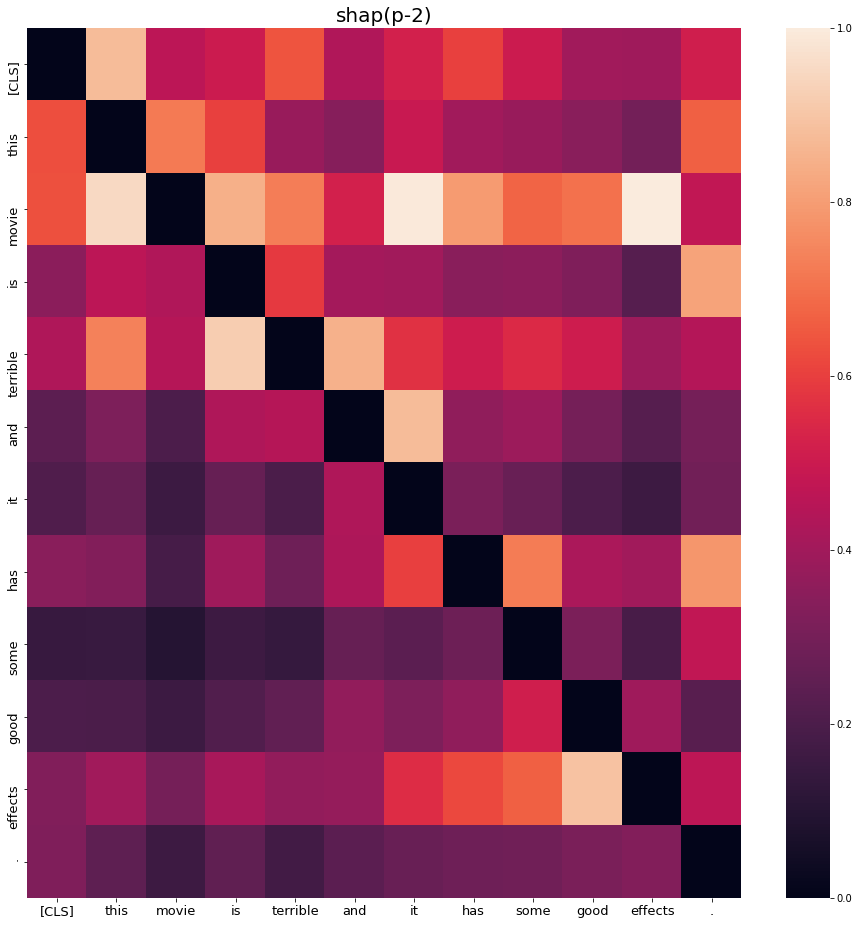

In [ ]:
res_dist_2 = res
normalize(res_dist_2[0])
tokenized_text = tokenizer.tokenize('[CLS] this movie is terrible and it has some good effects.')

x_tick = tokenized_text
y_tick = tokenized_text
data={}
for i in range(len(res_dist_2[0])):
  data[x_tick[i]] = res_dist_2[0][i]
  print(data[x_tick[i]])
pd_data=pd.DataFrame(data,index=y_tick,columns=x_tick)
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(pd_data,ax=ax)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13) 
#  (but->and good->bad)
plt.title('shap(p-2)',fontsize=20)

[0.0, 0.30279703919190887, 0.5520820690779938, 0.2664374754109446, 0.3245184297312139, 0.2220126958506348, 0.16207374899698088, 0.24987088753259426, 0.11450185135819782, 0.1956671451728634, 0.2881288144837946, 0.3306663544048275]
[0.33742934593637625, 0.0, 0.7235560339704133, 0.5756217980862344, 0.41502198598842444, 0.24893805619333037, 0.173777161451363, 0.2158315052371973, 0.10565089115751213, 0.13744162766902454, 0.21014038895511078, 0.13438252293194483]
[0.2206599272707562, 0.5468144238707645, 0.0, 0.7280491613115536, 0.6132161109971321, 0.31201449209617615, 0.16331441151923007, 0.2497610915942119, 0.10123796759892124, 0.13950396992689598, 0.3872838773348359, 0.1268378027204029]
[0.3287956374951403, 0.4119617240475294, 0.4910007452478337, 0.0, 0.6184306519959233, 0.4344027604408234, 0.19820845810613524, 0.23510177888939748, 0.1034049164799329, 0.12833372531688306, 0.2310671590468399, 0.12868939576906926]
[0.16941352003810992, 0.30315736682866323, 0.6196715236593411, 0.5324850037320

Text(0.5, 1.0, 'shap(p-2)')

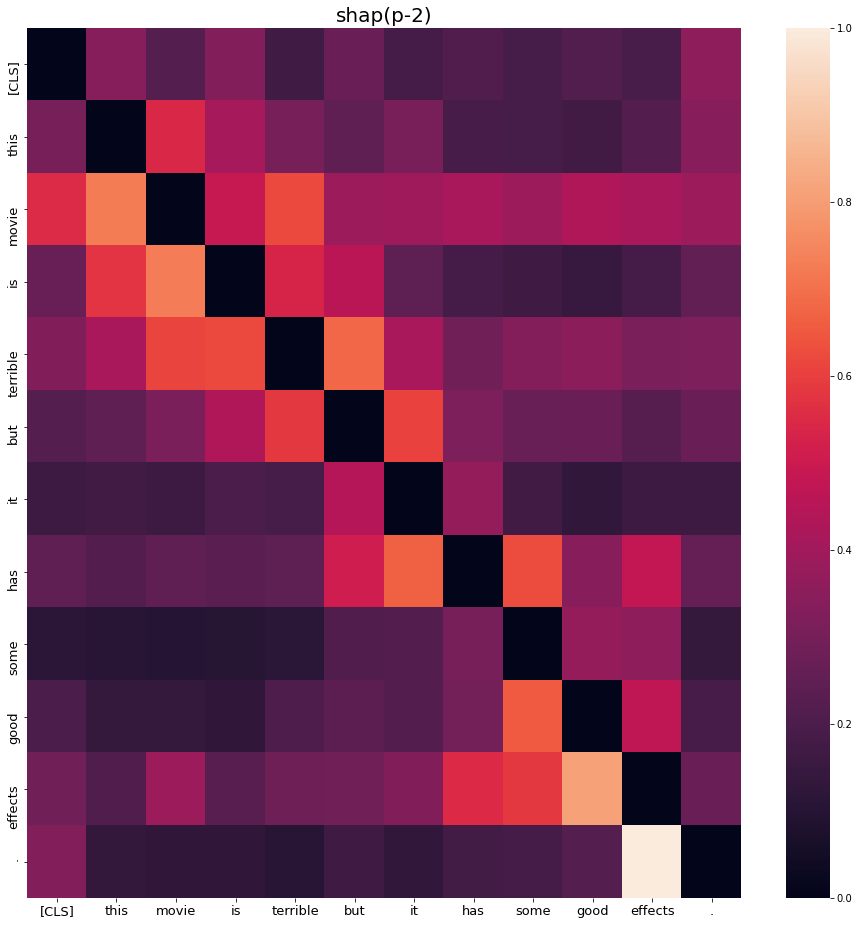

In [ ]:
res_dist = res
normalize(res_dist[0])
tokenized_text = tokenizer.tokenize('[CLS] this movie is terrible but it has some good effects.')

x_tick = tokenized_text
y_tick = tokenized_text
data={}
for i in range(len(res_dist[0])):
  data[x_tick[i]] = res_dist[0][i]
  print(data[x_tick[i]])
pd_data=pd.DataFrame(data,index=y_tick,columns=x_tick)
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(pd_data,ax=ax)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13) 
#  (but->and good->bad)
plt.title('shap(p-2)',fontsize=20)

[0.0, 0.32659618201004886, 0.083467652977531, 0.08152702917405191, 0.10524363757994287, 0.01874918473198242, 0.04878960951381081, 0.09506373251836106, 0.03339601328011971, 0.00724176494186593, 0.03805029057672621, -0.008394286893309844]
[0.5400931052992084, 0.0, 0.22944602394867963, -0.11409492556843215, 0.3199742727223218, 0.07098710536338121, 0.09019407238769087, 0.11333582151915883, 0.043467371822640974, 0.060235964121057944, 0.18906199899974224, 0.11170307998534404]
[0.2424537183226144, 0.17280210060392476, 0.0, -0.29119766123109025, -0.16580334524093082, -0.10968256934959464, -0.006717761677456191, -0.06450926693792058, -0.0008057208404981114, 0.017884025626299926, -0.08909104035540372, 0.03372996532581682]
[0.17198829746568334, 0.1898010899922199, 0.35492169929612866, 0.0, 0.3020095138050093, -0.0025002470369386853, 0.06499091462070566, 0.16160407075977873, 0.059861931859388165, 0.08539158121017906, 0.1851105098200027, 0.11930665784050193]
[0.4731413531169174, 0.07596223692808057

Text(0.5, 1.0, 'not mask - mask')

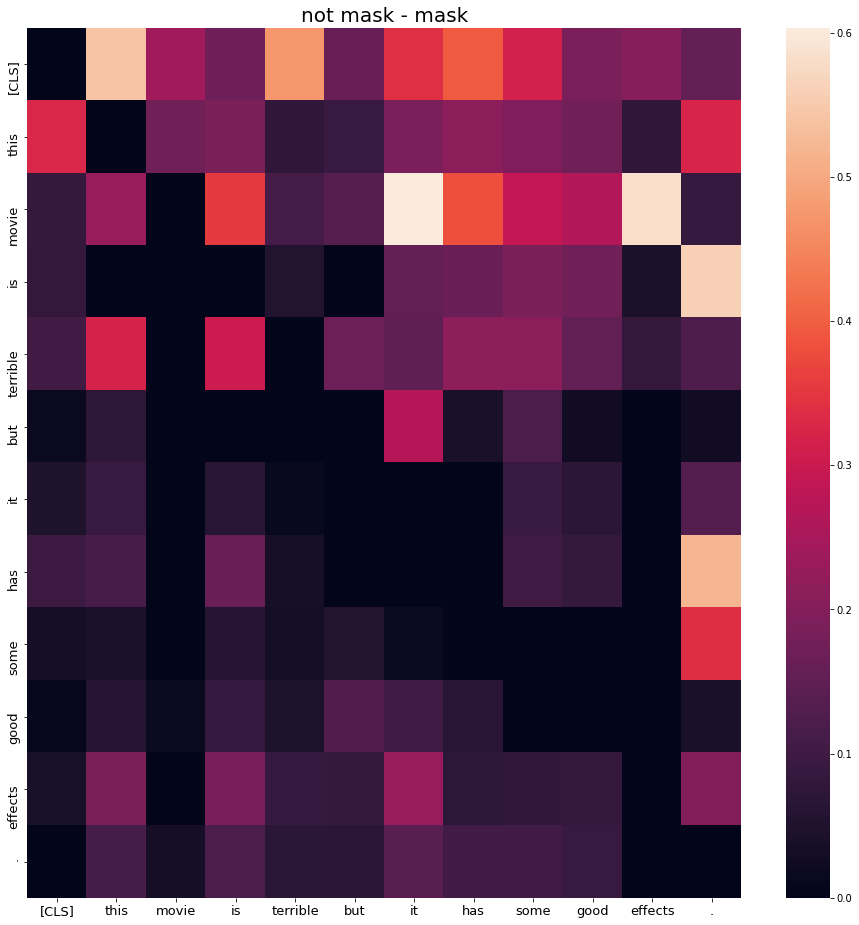

In [ ]:
d_dist = [[0 for i in range(len(res_dist[0]))] for j in range(len(res_dist[0]))]
vmaxd = -100
vmind = 10000
for i in range(len(res_dist[0])):
  for j in range(len(res_dist[0][0])):
    d_dist[i][j] = res_dist_2[0][i][j]-res_dist[0][i][j]
    # d_dist[i][j] = res_dist[0][i][j] - res_dist_2[0][i][j]
    # print(res_dist_2[0][i][j],res_dist[0][i][j])
    if d_dist[i][j]>vmaxd:
      vmaxd = d_dist[i][j]
    if d_dist[i][j]<vmind:
      vmind = d_dist[i][j]

x_tick = tokenized_text
y_tick = tokenized_text
data={}
for i in range(len(d_dist)):
  data[x_tick[i]] = d_dist[i]
  print(data[x_tick[i]])
pd_data=pd.DataFrame(data,index=y_tick,columns=x_tick)
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(pd_data,ax=ax,vmin=0, vmax=vmaxd)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13) 
#  (but->and good->bad)
plt.title('not mask - mask',fontsize=20)


## Dependency Probe

In [11]:
from utils import ConllUDataset
dataset = ConllUDataset('PUD.conllu')

dataset used: PUD.conllu


In [12]:
num = 0
sum = 0
sens = []
lines = []
tokes = []
for line in tqdm(dataset.tokens):
  sentence = [x.form for x in line][1:]
  leng = len(tokenizer.tokenize(' '.join(sentence)))
  if num>=100:
    break
  # if leng>12:
  #   continue
  print(leng)
  token_text = tokenizer.tokenize(' '.join(sentence))
  token_text.insert(0, '[CLS]')
  token_text.append('[SEP]')
  lines.append(line)
  tokes.append(token_text)
  sen = ' '.join(sentence)
  sens.append(sen)
  sum += leng
  num += 1

  0%|          | 0/1000 [00:00<?, ?it/s]

38
18
39
40
13
21
11
38
20
9
22
18
26
28
23
14
13
41
20
30
21
17
32
17
18
15
25
23
16
39
26
18
21
22
21
24
22
9
9
18
18
11
19
37
35
35
15
29
21
42
16
27
13
30
19
33
41
18
29
22
18
17
12
4
19
14
7
29
26
13
40
23
30
26
36
18
27
18
18
25
22
21
28
38
22
43
26
31
29
31
31
18
35
45
26
36
13
23
32
21


In [13]:
sum/num

23.96

In [10]:
print(num)

100


In [ ]:
sens[2]

'But in a break from his past rhetoric about curtailing immigration , the GOP nominee proclaimed that as president he would allow “ tremendous numbers ” of legal immigrants based on a “ merit system . ”'

In [ ]:
with open('train2.txt','w') as f:
  for line in sens:
    f.write(line+'\n')
  f.close()

In [ ]:
from utils_glue_txt import (convert_examples_to_features,output_modes, processors)
# from utils_glue import (convert_examples_to_features,output_modes, processors)
test_dataset = load_and_cache_examples(args, args.task_name, tokenizer, type='test')

[<utils_glue_txt.InputExample object at 0x7f302fe19410>, <utils_glue_txt.InputExample object at 0x7f302fe199d0>, <utils_glue_txt.InputExample object at 0x7f302fe19a50>, <utils_glue_txt.InputExample object at 0x7f302fe19ad0>, <utils_glue_txt.InputExample object at 0x7f302fe19b50>, <utils_glue_txt.InputExample object at 0x7f302fe19c10>, <utils_glue_txt.InputExample object at 0x7f302fe19c90>, <utils_glue_txt.InputExample object at 0x7f302fe19d10>, <utils_glue_txt.InputExample object at 0x7f302fe19d90>, <utils_glue_txt.InputExample object at 0x7f302fe19dd0>, <utils_glue_txt.InputExample object at 0x7f302fe19e50>, <utils_glue_txt.InputExample object at 0x7f302fe19ed0>, <utils_glue_txt.InputExample object at 0x7f302fe19f50>, <utils_glue_txt.InputExample object at 0x7f302fe19fd0>, <utils_glue_txt.InputExample object at 0x7f302fdc9090>, <utils_glue_txt.InputExample object at 0x7f302fdc9110>, <utils_glue_txt.InputExample object at 0x7f302fdc9190>, <utils_glue_txt.InputExample object at 0x7f302f

In [ ]:
res = []
start_pos = args.start_pos
end_pos = args.end_pos
with open('test.txt', 'w') as f:
  res = evaluate(args, model, tokenizer, test_dataset, f, start_pos, end_pos, args.visualize)

1
len: 20
first
sdhausd
111111111111
22222222222222
333333333
44444444444
2
len: 41
first
sdhausd
111111111111
22222222222222
333333333
44444444444
3
len: 42
first
sdhausd
111111111111
22222222222222
333333333
44444444444
4
len: 15
first
sdhausd
111111111111
22222222222222
333333333
44444444444
5
len: 23
first
sdhausd
111111111111
22222222222222
333333333
44444444444
6
len: 13
first
sdhausd
111111111111
22222222222222
333333333
44444444444
7
len: 40
first
sdhausd
111111111111
22222222222222
333333333
44444444444
8
len: 22
first
sdhausd
111111111111
22222222222222
333333333
44444444444
9
len: 11
first
sdhausd
111111111111
22222222222222
333333333
44444444444
10
len: 24
first
sdhausd
111111111111
22222222222222
333333333
44444444444
11
len: 20
first
sdhausd
111111111111
22222222222222
333333333
44444444444
12
len: 28
first
sdhausd
111111111111
22222222222222
333333333
44444444444
13
len: 30
first
sdhausd
111111111111
22222222222222
333333333
44444444444
14
len: 25
first
sdhausd
111111111

KeyboardInterrupt: ignored

In [ ]:
res2 = res
for line in res2:
  for i in line:
    i.insert(0,0)
    i.append(0)
  line.insert(0,[0 for i in range(len(line[0]))])
  line.append([0 for i in range(len(line[0]))])

In [ ]:
num = 0
sum = 0
in_result = []
for line in tqdm(dataset.tokens):
  sentence = [x.form for x in line][1:]
  # print(sentence)
  leng = len(tokenizer.tokenize(' '.join(sentence)))
  if leng>12:
    continue
  if num==0:
    num+=1
    continue
  print(num)
  token_text = tokenizer.tokenize(' '.join(sentence))
  token_text.insert(0, '[CLS]')
  token_text.append('[SEP]')
  # print(len(res[num-1]))
  # print(len(line))
  # print(len(res[num-1]))
  in_result.append((line,token_text,res2[num-1]))
  # print(line)
  sen = ' '.join(sentence)
  sens.append(sen)
  sum += leng
  num += 1

 42%|████▏     | 416/1000 [00:00<00:00, 2040.30it/s]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57


 78%|███████▊  | 783/1000 [00:00<00:00, 1935.20it/s]

58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102


100%|██████████| 1000/1000 [00:00<00:00, 1913.38it/s]


In [ ]:
len(res[0][])

SyntaxError: ignored

In [ ]:
from dependency import _evaluation as dep_eval
from dependency.dep_parsing import decoding as dep_parsing
class arg2(object):
  def __init__(self):
    self.probe = 'discourse'
    self.decoder = 'eisner'
    self.subword = 'avg'
    self.root = 'gold'
args = arg2()
trees, results, deprels = dep_parsing(in_result[0:99],args)
dep_eval(trees, results)

100%|██████████| 99/99 [00:00<00:00, 478.39it/s]

UAS, UUAS, NED: 0.6255707762557078 0.6518264840182648 0.815068493150685
correct and total arcs 548.0 876.0


(0.6255707762557078, 0.6518264840182648, 0.815068493150685)

m=0
UAS, UUAS, NED: 0.5947488584474886 0.636986301369863 0.7671232876712328
correct and total arcs 521.0 876.0

(0.5947488584474886, 0.636986301369863, 0.7671232876712328)

UAS, UUAS, NED: 0.6255707762557078 0.6518264840182648 0.815068493150685
correct and total arcs 548.0 876.0

(0.6255707762557078, 0.6518264840182648, 0.815068493150685)


In [ ]:
# nohup python run_shap.py >> 1.log 2>&1 &
# 0 105959

import numpy as np
import itertools
from itertools import combinations
import torch
from copy import deepcopy
# from __future__ import absolute_import, division, print_function

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import argparse
import glob
import logging
import os
import random
import itertools
import numpy as np
import torch
# import hedge_bert as hedge
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange
from copy import copy, deepcopy
# from pytorch_transformers import (WEIGHTS_NAME, BertConfig,BertForSequenceClassification, BertTokenizer)

# from pytorch_transformers import AdamW, WarmupLinearSchedule

from utils_glue import (convert_examples_to_features,output_modes, processors)
import time
logger = logging.getLogger(__name__)

# torch.cuda.set_device(1)

def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

def load_and_cache_examples(args, task, tokenizer, type):
    processor = processors[task]()
    output_mode = output_modes[task]
    label_list = processor.get_labels()
    cached_features_file = os.path.join(args.data_dir, 'cached_{}_{}_{}_{}'.format(
        type,
        list(filter(None, args.model_name_or_path.split('/'))).pop(),
        str(args.max_seq_length),
        str(task)))
    examples = processor.get_train_examples(args.data_dir)
    #print(examples)
    # examples = ['By comparison , it cost $ 103.7 million to build the NoMa infill Metro station , which opened in 2004 .']
    # label_list = ['pos','neg']
    output_mode = output_modes[task]
    
    features = convert_examples_to_features(examples, label_list, args.max_seq_length, tokenizer, output_mode,
                                            cls_token_at_end=bool(args.model_type in ['xlnet']),
                                            # xlnet has a cls token at the end
                                            cls_token=tokenizer.cls_token,
                                            cls_token_segment_id=2 if args.model_type in ['xlnet'] else 0,
                                            sep_token=tokenizer.sep_token,
                                            sep_token_extra=bool(args.model_type in ['roberta']),
                                            # roberta uses an extra separator b/w pairs of sentences, cf. github.com/pytorch/fairseq/commit/1684e166e3da03f5b600dbb7855cb98ddfcd0805
                                            pad_on_left=bool(args.model_type in ['xlnet']),
                                            # pad on the left for xlnet
                                            pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                                            pad_token_segment_id=4 if args.model_type in ['xlnet'] else 0,
                                            )
    logger.info("Saving features into cached file %s", cached_features_file)
    torch.save(features, cached_features_file)
    
    # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    #for f in features:
    #  print(f.ori_token)
    if output_mode == "classification":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    elif output_mode == "regression":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.float)
    dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    return dataset
	
class arg(object):
  def __init__(self):
    self.data_dir = './dataset/IMDB'
    self.model_type = 'bert'
    self.model_name_or_path = 'bert-base-uncased' 
    # self.model_name_or_path = 'gilf/english-yelp-sentiment'
    self.task_name = 'sst-2'
    self.output_dir = './output/IMDB'
    self.max_seq_length = 250
    self.start_pos = 0
    self.end_pos = 2000
    self.visualize = 1
    self.per_gpu_eval_batch_size = 1
    self.n_gpu = 1
    self.device = 'cuda'
args = arg()

def evaluate(args, model, tokenizer, eval_dataset, fileobject, start_pos=0, end_pos=100, vis=-1):
    eval_output_dir = args.output_dir
    if not os.path.exists(eval_output_dir):
        os.makedirs(eval_output_dir)

    args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)
    # Note that DistributedSampler samples randomly
    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=1)

    # Eval!
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    count = start_pos
    start_time = time.time()
    results = []
    num =0
    for batch in itertools.islice(eval_dataloader, start_pos, end_pos):
        num+=1
        print(num)
        model.eval()
        batch = tuple(t.to(args.device) for t in batch)
        count += 1
        fileobject.write(str(count))
        fileobject.write('\n')
        
        ori_text_idx = list(batch[0].cpu().numpy()[0])
        if 0 in ori_text_idx:
            ori_text_idx = [idx for idx in ori_text_idx if idx != 0]
        pad_start = len(ori_text_idx)
        print('len:',pad_start)
        with torch.no_grad():
            inputs = {'input_ids':      torch.unsqueeze(batch[0][0,:pad_start], 0),
                  'attention_mask': torch.unsqueeze(batch[1][0,:pad_start], 0),
                  'token_type_ids': torch.unsqueeze(batch[2][0,:pad_start], 0) if args.model_type in ['bert', 'xlnet'] else None,  # XLM and RoBERTa don't use segment_ids
                  'labels':         batch[3]}
            # print(inputs)
            outputs = model(**inputs)
            global tttest
            tttest = outputs[-1]
            # print(len(outputs))
            # print(outputs)
            tmp_eval_loss, logits = outputs[:2]

            eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        
        # print(count,len(inputs['input_ids'][0]) - 2)
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs['labels'].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

        for btxt in ori_text_idx:
            if (tokenizer.ids_to_tokens[btxt] != '[CLS]' and tokenizer.ids_to_tokens[btxt] != '[SEP]'):
                fileobject.write(tokenizer.ids_to_tokens[btxt])
                fileobject.write(' ')
        fileobject.write(' >> ')
        if batch[3].cpu().numpy()[0] == 0:
            fileobject.write('0')
            fileobject.write(' ||| ')
        else:
            fileobject.write('1')
            fileobject.write(' ||| ')

        shap = HEDGE(model, inputs, args, thre=100)
        res = shap.shapely_matrix(model,inputs)
        results.append(res)
    return results
	
class HEDGE:
    def __init__(self, model, inputs, args, max_level=-1, thre=0.3):
        score = model(**inputs)[1].detach().cpu().numpy()
        score_norm = (np.exp(score) / np.sum(np.exp(score), axis=1))
        self.pred_label = np.argmax(score_norm)
        self.max_level = max_level
        self.output = []
        self.fea_num = len(inputs['input_ids'][0]) - 2
        self.level = 0
        self.args = args
        self.thre = thre
        input = inputs['input_ids'][0]
        mask_input = torch.zeros(input.shape, dtype=torch.long)
        mask_attention = torch.zeros(input.shape, dtype=torch.long)
        mask_type = torch.zeros(input.shape, dtype=torch.long)
        temp = {'input_ids': torch.unsqueeze(mask_input, 0).to(args.device),
                'attention_mask': torch.unsqueeze(mask_attention, 0).to(args.device),
                'token_type_ids': torch.unsqueeze(mask_type, 0).to(args.device),
                'labels': inputs['labels']}
        # score = model(**temp)[1].detach().cpu().numpy()
        # score_norm = (np.exp(score) / np.sum(np.exp(score), axis=1))
        with torch.no_grad():
          ori_score = model(**temp)[-1][12].cpu().numpy()
          # ori_score = ori_score[0]
        self.ori_score = ori_score

    def set_contribution_func(self, model, fea_set, inputs, ori,tar):
      # input has just one sentence, input is a list
      args = self.args
      input = inputs['input_ids'][0]
      mask_input = torch.full(input.shape,tokenizer.mask_token_id)
      mask_input[0] = input[0]
      mask_input[-1] = input[-1]
      mask_attention = torch.zeros(input.shape, dtype=torch.long)
      mask_attention[0] = 1
      mask_attention[-1] = 1
      # mask_attention[ori+1] = 1
      # mask_input[ori+1] = input[ori+1]
      mask_type = torch.zeros(input.shape, dtype=torch.long)

      # mask the input with zero
      for fea_idx in fea_set:
          if type(fea_idx) == int:
              mask_input[fea_idx+1] = input[fea_idx+1] #+1 accounts for the CLS token at the begining
              mask_attention[fea_idx+1] = 1 #+1 accounts for the CLS token at the begining
          else:
              for idx in fea_idx:
                  mask_input[idx+1] = input[idx+1] #+1 accounts for the CLS token at the begining
                  mask_attention[idx+1] = 1 #+1 accounts for the CLS token at the begining
      temp = {'input_ids': torch.unsqueeze(mask_input, 0).to(args.device),
              'attention_mask': torch.unsqueeze(mask_attention, 0).to(args.device),
              'token_type_ids': torch.unsqueeze(mask_type, 0).to(args.device),
              'labels': inputs['labels']}
      # send the mask_input into model
      with torch.no_grad():
        score = model(**temp)[-1][12][:, ori+1, :].cpu().numpy()
        score = score[0]
      # score = score[12][:, word_pos, :] 
      # print(mask_attention)
      mask_input[tar+1] = input[tar+1]
      mask_attention[tar+1] = 1

      temp = {'input_ids': torch.unsqueeze(mask_input, 0).to(args.device),
              'attention_mask': torch.unsqueeze(mask_attention, 0).to(args.device),
              'token_type_ids': torch.unsqueeze(mask_type, 0).to(args.device),
              'labels': inputs['labels']}

      with torch.no_grad():
        score2 = model(**temp)[-1][12][:, ori+1, :].cpu().numpy()
        score2 = score2[0]
      # print(mask_attention)
      # print(score)
      # print(score2)
      return np.linalg.norm(score - score2)
      # return np.dot(score, score2) / (np.linalg.norm(score) * np.linalg.norm(score2))

    def shapely_matrix(self,model,inputs):
      fea_num = self.fea_num
      if fea_num == 0:
        return -1
      fea_set = list(range(fea_num))
      scores = [[] for i in range(len(fea_set))]
      for i in fea_set:
        for j in fea_set:
          if i==j:
            scores[i].append(0)
            continue
          # print(i,j)
          new_fea_set = [ele for x, ele in enumerate(fea_set) if x!=j and x!=i]
          # print(new_fea_set)
          scores[i].append(self.shapely_value(model,inputs,new_fea_set,i,j))
      return scores

    def get_shapley_interaction_weight(self, d, s):
      return np.math.factorial(s) * np.math.factorial(d - s - 1) / np.math.factorial(d)

    def shapely_value(self,model,inputs,feature_set,ori,tar):
      fea_num = len(feature_set)
      #dict_subset = {r: list(combinations(feature_set, r)) for r in range(fea_num+1)}
      score = 0.0
      for i in range(fea_num+1):
        # if i<(fea_num+1)*0.9:
        #   continue
        if i<fea_num-1:
          continue
        weight = self.get_shapley_interaction_weight(fea_num+1, i)
        if i==0:
          continue
        i_subsets = list(combinations(feature_set,i))
        for subsets in i_subsets:
          contri = self.set_contribution_func(model,list(subsets),inputs,ori,tar)
          score += contri*weight

      # print(score)
      return score


from transformers import BertModel, BertTokenizer,BertForSequenceClassification,RobertaModel,RobertaTokenizer,RobertaForSequenceClassification
# MODEL_CLASSES = {
#         'bert': (BertModel, BertTokenizer, 'gilf/english-yelp-sentiment'),
#         'roberta': (RobertaModel, RobertaTokenizer,'roberta-base')
#     }
MODEL_CLASSES = {
        'bert': (BertModel, BertTokenizer, 'bert-base-uncased'),
    }
model_class, tokenizer_class, pretrained_weights = MODEL_CLASSES['bert']
# model = RobertaForSequenceClassification.from_pretrained(pretrained_weights, output_hidden_states=True)
model = BertForSequenceClassification.from_pretrained(pretrained_weights, output_hidden_states=True,cache_dir='cache_dir')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights, do_lower_case=True,cache_dir='cache_dir')
# from transformers import AutoTokenizer, AutoModelForSequenceClassification
  
# tokenizer = AutoTokenizer.from_pretrained("barissayil/bert-sentiment-analysis-sst",use_fast=False, do_lower_case=True)

# model = AutoModelForSequenceClassification.from_pretrained("barissayil/bert-sentiment-analysis-sst",output_hidden_states=True)

model.to('cuda')


from utils import ConllUDataset
dataset = ConllUDataset('PUD.conllu')

from utils_glue_txt import (convert_examples_to_features,output_modes, processors)
# from utils_glue import (convert_examples_to_features,output_modes, processors)
test_dataset = load_and_cache_examples(args, args.task_name, tokenizer, type='test')

res = []
start_pos = args.start_pos
end_pos = args.end_pos
cnt = 0
with open('test.txt', 'w') as f:
  print(cnt)
  cnt +=1
  res = evaluate(args, model, tokenizer, test_dataset, f, start_pos, end_pos, args.visualize)
  
res2 = res
for line in res2:
  for i in line:
    i.insert(0,0)
    i.append(0)
  line.insert(0,[0 for i in range(len(line[0]))])
  line.append([0 for i in range(len(line[0]))])
  
num = 0
sum = 0
in_result = []
sens = []
for line in tqdm(dataset.tokens):
  sentence = [x.form for x in line][1:]
  # print(sentence)
  leng = len(tokenizer.tokenize(' '.join(sentence)))
  if num==0:
    num+=1
    continue
  if num>=100:
    break
  print(num)
  token_text = tokenizer.tokenize(' '.join(sentence))
  token_text.insert(0, '[CLS]')
  token_text.append('[SEP]')
  # print(len(res[num-1]))
  # print(len(line))
  # print(len(res[num-1]))
  in_result.append((line,token_text,res2[num-1]))
  # print(line)
  sen = ' '.join(sentence)
  sens.append(sen)
  sum += leng
  num += 1


from dependency import _evaluation as dep_eval
from dependency.dep_parsing import decoding as dep_parsing
class arg2(object):
  def __init__(self):
    self.probe = 'discourse'
    self.decoder = 'eisner'
    self.subword = 'avg'
    self.root = 'gold'
args = arg2()
trees, results, deprels = dep_parsing(in_result[0:99],args)
dep_eval(trees, results)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

dataset used: PUD.conllu
0
1
len: 20


0 100 UAS, UUAS, NED: 0.4060081929904415 0.5011379153390988 0.5885298133818844
correct and total arcs 892.0 2197.0
(0.4060081929904415, 0.5011379153390988, 0.5885298133818844)

 0.42011834319526625 0.5106964041875285 0.6071916249431042